# Introduction

**Seasonality** is a commonly held belief in the real estate industry (I have been a real estate agent for 5 years), yet there is no significant data to support this idea that the same home sold at different times of year will yield a different price. The assumption is based on demand; it's believed in the spring there is a higher demand as there are more home shoppers on the market as opposed to winter when family events and year end tax implications may impact decisions or pricing.

# Hypothesis

Null Hypothesis = there is no significant difference in sales price relative to season.

Alternative Hypothesis = there is a significant difference in sales price relative to season.

# Data

The data comes from Alachua County Property Appraiser, the local government agency that handles all Gainesville transactions. 4515 observations and 35 variables are in the original data set, which spans from Januuary 2017 to January 2019 and covers all sales of real estate in Gainesville, FL. 

Some sales data will be omitted that doesn't match the parameters of this study. This includes any intrinsically non-residential properties, and includes investment multifamily. It will, however, include residential houses bought for investment purchases due to their impact on general market value.

Seven variables have null values for a majority of their records. These are: Improvement_Value, Deferred_Value, Land_Value, Classified_land_value, County_Exempt_Amount, Owner_Mail_Country, Owner_Mail_addr1 and School_Exempt_Amount.

In [0]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

allsales = pd.read_csv('http://www.acpafl.org/DownloadData/Sales2019125132251.csv')

allsales.columns = allsales.columns.str.lower()

allsales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4515 entries, 0 to 4514
Data columns (total 35 columns):
parcel                   4515 non-null object
owner_mail_name          4515 non-null object
owner_mail_addr1         32 non-null object
owner_mail_addr2         4515 non-null object
owner_mail_city          4515 non-null object
owner_mail_state         4509 non-null object
owner_mail_zip           4508 non-null object
owner_mail_country       11 non-null object
section                  4515 non-null int64
township                 4515 non-null int64
range                    4515 non-null int64
city_code                4515 non-null int64
city_desc                4515 non-null object
prop_use_code            4515 non-null int64
prop_use_desc            4515 non-null object
nbhd_code                4515 non-null float64
nbhd_desc                4515 non-null object
htdsqft                  4515 non-null int64
acres                    4514 non-null float64
sbdv_code                44

# Methods : Cleaning Base Data 1

For this analysis I will first isolate the desired residential transactions for this analysis into their own dataframe. From there I will segment my data into four variables representing each season over the two year span.

Use histogram first to determine what the range of pricing is, get rid of outliers, and subdivide into seasons from there. Then use seasonal segmentations. 

Cleaning Base Data 1 is focused on cleaning the base data prior to segmenting, getting rid of columns, data that isn't relevant, and eliminating outliers.

In [0]:
# Here I am cleaning up my data to only have the desired transaction types

allsales.columns

allsales.prop_use_desc.unique()

residential_sales_all = allsales[(allsales['prop_use_desc'] == 'SINGLE FAMILY') | (allsales['prop_use_desc'] == 'CONDOMINIUM')]


# After segmenting out residential sales I decided to select specific columns relevant to my analysis


residential_sales_columns= residential_sales_all[['parcel', 'loc_address', 'htdsqft', 'acres', 'sale_date', 'sale_price']]

residential_sales_columns.info()


# Detected some null values in loc_address, decided to drop that data


residential_sales_no_na = residential_sales_columns.dropna()

residential_sales_no_na.info()


# looks good so far, going to sort_values(sale_price) to see if there are any values that are outliers


residential_sales_no_na.sort_values(by = 'sale_price')


# here I see there are two aspects of the data that need cleaning: 1) there are a bunch of 0 value homes,
# which indicates a transfer of ownership outside of a traditional sale, & 
# 2) repeated high number sales value
# which indicates an assemblage sale of a portfolio of properties (also not of interest)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3768 entries, 0 to 4514
Data columns (total 6 columns):
parcel         3768 non-null object
loc_address    3426 non-null object
htdsqft        3768 non-null int64
acres          3768 non-null float64
sale_date      3768 non-null object
sale_price     3768 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 206.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3426 entries, 0 to 4514
Data columns (total 6 columns):
parcel         3426 non-null object
loc_address    3426 non-null object
htdsqft        3426 non-null int64
acres          3426 non-null float64
sale_date      3426 non-null object
sale_price     3426 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 187.4+ KB


,parcel,loc_address,htdsqft,acres,sale_date,sale_price
380,06014-026-010,6310 NW 26TH TER,1481,0.25,2019-07-24,0
1459,06449-042-000,418 NW 27TH TER,1340,0.18,2019-05-21,0
1051,06105-082-000,3646 NW 23RD PL,1671,0.41,2018-08-31,0
3688,10360-000-000,1114 NE 6TH ST,1245,0.22,2019-04-04,0
2790,07917-100-028,1610 NW 42ND AVE,1558,0.21,2018-10-08,0
...,...,...,...,...,...,...
4068,13222-010-004,1030 SW 1ST AVE,1706,0.00,2018-06-14,17800000
4069,13222-010-005,1024 SW 1ST AVE,1158,0.00,2018-06-14,17800000
4065,13222-010-001,1022 SW 1ST AVE,1254,0.00,2018-06-14,17800000
4036,13089-000-000,325 SW 12TH ST,1627,0.14,2018-06-14,17800000


In [0]:
no_zeros = residential_sales_no_na['sale_price'] > 0 
residential_sales_no_zeros = residential_sales_no_na.iloc[no_zeros.values]

# let see if that takes care of all the bottom end outliers

residential_sales_no_zeros.sort_values(by = 'sale_price')

# looks like there are a bunch of values for $100 too, which is another method
# of transfering property and doesn't represent real sales. In fact, I'd prefer 
# to avoid any transactions under $20,000 as those likely don't represent traditional transactions

no_ones_either  = residential_sales_no_zeros['sale_price'] > 20000
re_sales_bottom_clean = residential_sales_no_zeros.iloc[no_ones_either.values]

re_sales_bottom_clean.info()

# now I need to sort the top end and see if there are any duplicates for the portfolio sales
# I plan on doing this by organizing by creating a new column that concatinates sale_date and sale_price.
# I do this because while there are likely duplicate sales values under sales price, it's highly unlikely that both
# price and date would be exactly the same.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3211 entries, 0 to 4514
Data columns (total 6 columns):
parcel         3211 non-null object
loc_address    3211 non-null object
htdsqft        3211 non-null int64
acres          3211 non-null float64
sale_date      3211 non-null object
sale_price     3211 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 175.6+ KB


In [0]:
re_sales_bottom_clean = re_sales_bottom_clean.assign(date_price_combo = (re_sales_bottom_clean.sale_price).astype(str) + '' + (re_sales_bottom_clean.sale_date).astype(str))

re_sales_clean = re_sales_bottom_clean.drop_duplicates(subset='date_price_combo')

#worked great, now time to get rid of the extra created column

re_sales_clean.drop(['date_price_combo'], axis = 1, inplace = True)

re_sales_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3135 entries, 0 to 4514
Data columns (total 6 columns):
parcel         3135 non-null object
loc_address    3135 non-null object
htdsqft        3135 non-null int64
acres          3135 non-null float64
sale_date      3135 non-null object
sale_price     3135 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 171.4+ KB


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


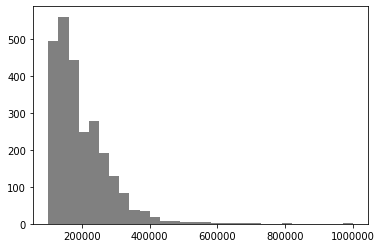

DescribeResult(nobs=3135, minmax=(22000, 17800000), mean=181643.8644338118, variance=109615732670.6731, skewness=48.211042808675856, kurtosis=2556.937203187635)


In [0]:
# now that my data is relatively clean, I'm going to run a histogram to check the general distribution before 
# further segmenting. 


plt.hist(re_sales_clean['sale_price'], 30, range=[100000, 1000000], facecolor='gray', align='mid')
plt.show()
print(stats.describe(re_sales_clean['sale_price']))

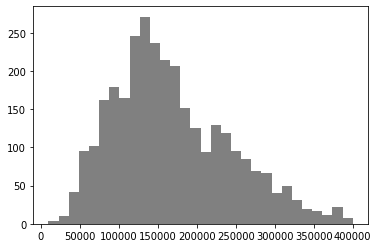

DescribeResult(nobs=3068, minmax=(22000, 399000), mean=167302.21186440677, variance=5575531598.1272545, skewness=0.6434556375121188, kurtosis=-0.057785727683985044)


In [0]:
# There are definitely some outliers I want to drop off my histogram range, it looks like the majority of my data set
# falls under the 400,000 range so I will filter then run another histogram to try and remove outlier systematically

outliers_gone_1  = re_sales_clean['sale_price'] < 400000

re_sales_cleanish = re_sales_clean.iloc[outliers_gone_1.values]

plt.hist(re_sales_cleanish['sale_price'], 30, range=[10000, 400000], facecolor='gray', align='mid')
plt.show()
print(stats.describe(re_sales_cleanish['sale_price']))

In [0]:
# that looks relatively normal for the base data set, but I want to shapiro-wilk test for normality

print(stats.shapiro(re_sales_cleanish['sale_price']))

# the w value looks to be very close to one, and the p value is very low so I feel confident in the normality in this base set

(0.9651998281478882, 1.349271698224303e-26)


# Methods: Segmenting into Seasons

Here I will begin to segment my base data into different seasons over the two year span. I believe the most efficient method is to create a new column for each season.

In [0]:
re_sales_cleanish.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3068 entries, 0 to 4514
Data columns (total 6 columns):
parcel         3068 non-null object
loc_address    3068 non-null object
htdsqft        3068 non-null int64
acres          3068 non-null float64
sale_date      3068 non-null object
sale_price     3068 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 167.8+ KB


In [0]:
re_sales_cleanish = re_sales_cleanish.assign(sale_date_string = (re_sales_cleanish.sale_date).astype(str))

re_sales_cleanish[['Year','Month', 'Day']] = re_sales_cleanish.sale_date_string.str.split("-",expand=True,)

re_sales_cleanish.Month.unique()

def season(x):
    if "3" in x or "4" in x or "5" in x:
        return 'Spring'
    elif "6" in x or "7" in x or "8" in x:
        return 'Summer'
    elif "9" in x or "10" in x or "11" in x:
        return 'Autumn'
    else: return 'Winter'

re_sales_cleanish['Season'] = re_sales_cleanish['Month'].apply(season)

# now that I've created a column to identify season based on month, I'll segment my data and analyze each season

re_sales_spring = re_sales_cleanish[re_sales_cleanish['Season'] == 'Spring']

re_sales_summer = re_sales_cleanish[re_sales_cleanish['Season'] == 'Summer']

re_sales_autumn = re_sales_cleanish[re_sales_cleanish['Season'] == 'Autumn']

re_sales_winter = re_sales_cleanish[re_sales_cleanish['Season'] == 'Winter']


# Methods: Spring Analysis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 935 entries, 0 to 4491
Data columns (total 11 columns):
parcel              935 non-null object
loc_address         935 non-null object
htdsqft             935 non-null int64
acres               935 non-null float64
sale_date           935 non-null object
sale_price          935 non-null int64
sale_date_string    935 non-null object
Year                935 non-null object
Month               935 non-null object
Day                 935 non-null object
Season              935 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 87.7+ KB
           htdsqft       acres     sale_price
count   935.000000  935.000000     935.000000
mean   1478.866310    0.192083  168304.171123
std     531.059079    0.190455   74787.904341
min       0.000000    0.010000   22000.000000
25%    1131.500000    0.030000  115000.000000
50%    1361.000000    0.170000  152000.000000
75%    1733.000000    0.270000  218900.000000
max    4681.000000    1.

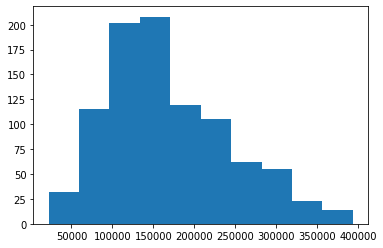

DescribeResult(nobs=935, minmax=(22000, 394000), mean=168304.17112299465, variance=5593230635.68803, skewness=0.6559724429223006, kurtosis=-0.08032717502833409)
(0.9623806476593018, 8.664084024062688e-15)


In [0]:
# Analysis for spring, looks normal!
re_sales_spring.info()

print(re_sales_spring.describe())

plt.hist(re_sales_spring['sale_price'])
plt.show()

print(stats.describe(re_sales_spring['sale_price']))
print(stats.shapiro(re_sales_spring['sale_price']))


# Methods: Summer Analysis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 3 to 4514
Data columns (total 11 columns):
parcel              983 non-null object
loc_address         983 non-null object
htdsqft             983 non-null int64
acres               983 non-null float64
sale_date           983 non-null object
sale_price          983 non-null int64
sale_date_string    983 non-null object
Year                983 non-null object
Month               983 non-null object
Day                 983 non-null object
Season              983 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 92.2+ KB
           htdsqft       acres     sale_price
count   983.000000  983.000000     983.000000
mean   1475.186165    0.207185  167280.162767
std     494.013577    0.299372   74654.145830
min       0.000000    0.010000   22000.000000
25%    1138.000000    0.040000  112250.000000
50%    1364.000000    0.180000  156000.000000
75%    1750.500000    0.270000  216000.000000
max    3612.000000    5.

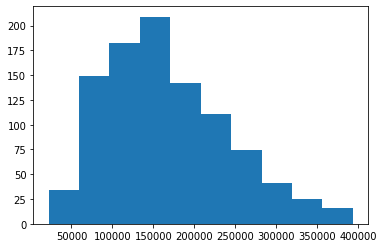

DescribeResult(nobs=983, minmax=(22000, 394000), mean=167280.16276703967, variance=5573241489.562075, skewness=0.6544135069547149, kurtosis=-0.03444558566843536)
(0.9638051986694336, 6.692239180216197e-15)


In [0]:
# summer looks normal as well
re_sales_summer.info()

print(re_sales_summer.describe())

plt.hist(re_sales_summer['sale_price'])
plt.show()

print(stats.describe(re_sales_summer['sale_price']))
print(stats.shapiro(re_sales_summer['sale_price']))

# Methods: Autumn Analysis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571 entries, 11 to 4513
Data columns (total 11 columns):
parcel              571 non-null object
loc_address         571 non-null object
htdsqft             571 non-null int64
acres               571 non-null float64
sale_date           571 non-null object
sale_price          571 non-null int64
sale_date_string    571 non-null object
Year                571 non-null object
Month               571 non-null object
Day                 571 non-null object
Season              571 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 53.5+ KB
           htdsqft       acres     sale_price
count   571.000000  571.000000     571.000000
mean   1501.290718    0.218047  169786.964974
std     495.582736    0.445379   75641.529462
min       0.000000    0.000000   33000.000000
25%    1172.000000    0.077500  119000.000000
50%    1400.000000    0.190000  156000.000000
75%    1739.500000    0.260000  216500.000000
max    4582.000000   10

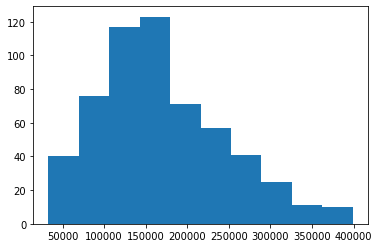

DescribeResult(nobs=571, minmax=(33000, 399000), mean=169786.9649737303, variance=5721640979.3496475, skewness=0.6745578344129279, kurtosis=0.05070501249824888)
(0.9626743793487549, 7.369280186075855e-11)


In [0]:
# autumn looks normal
re_sales_autumn.info()

print(re_sales_autumn.describe())

plt.hist(re_sales_autumn['sale_price'])
plt.show()

print(stats.describe(re_sales_autumn['sale_price']))
print(stats.shapiro(re_sales_autumn['sale_price']))

# Methods: Winter Analysis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 1 to 4510
Data columns (total 11 columns):
parcel              579 non-null object
loc_address         579 non-null object
htdsqft             579 non-null int64
acres               579 non-null float64
sale_date           579 non-null object
sale_price          579 non-null int64
sale_date_string    579 non-null object
Year                579 non-null object
Month               579 non-null object
Day                 579 non-null object
Season              579 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 54.3+ KB
           htdsqft       acres     sale_price
count   579.000000  579.000000     579.000000
mean   1459.466321    0.179979  163271.207254
std     485.558769    0.152139   73564.072168
min     267.000000    0.000000   23000.000000
25%    1138.500000    0.045000  112000.000000
50%    1361.000000    0.170000  150000.000000
75%    1764.500000    0.255000  217100.000000
max    3160.000000    1.

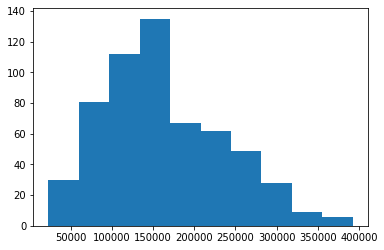

DescribeResult(nobs=579, minmax=(23000, 392500), mean=163271.207253886, variance=5411672713.905069, skewness=0.5655239043967277, kurtosis=-0.2186502661462626)
(0.9677886962890625, 5.793407975573928e-10)


In [0]:
# Winter looks normal enough
re_sales_winter.info()

print(re_sales_winter.describe())

plt.hist(re_sales_winter['sale_price'])
plt.show()

print(stats.describe(re_sales_winter['sale_price']))
print(stats.shapiro(re_sales_winter['sale_price']))

# Methods: Comparing Seasonality

Since all seasons have enough samples and are normal, I will run a group parametric test to see if there are significant differences between the sales prices. Anova and Tukey should provide some interesting insights on these independent variables.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f095e265f98>,
      dtype=object)

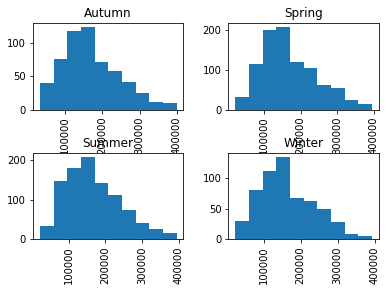

In [0]:
re_sales_cleanish['sale_price'].hist(by = re_sales_cleanish['Season'])

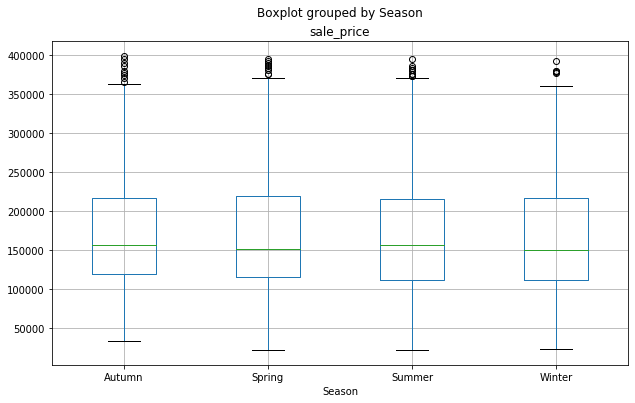

In [0]:
re_sales_cleanish.boxplot('sale_price', by='Season', figsize=(10, 6))

In [0]:
# Anova test - from the Anova test there doesn't seem to be a significant difference in sales price

stats.f_oneway(re_sales_spring['sale_price'], re_sales_summer['sale_price'], re_sales_autumn['sale_price'], re_sales_winter['sale_price'])

F_onewayResult(statistic=0.8292393713168614, pvalue=0.4776242905711011)

In [0]:
# Tukey further shows that the mean sales price fails to reject the null across all groups
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog = re_sales_cleanish['sale_price'],      
                          groups = re_sales_cleanish['Season'],  
                          alpha=0.05)         
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Autumn,Spring,-1482.7939,0.9,-11677.5151,8711.9274,False
Autumn,Summer,-2506.8022,0.9,-12606.7103,7593.1059,False
Autumn,Winter,-6515.7577,0.4515,-17836.5889,4805.0734,False
Spring,Summer,-1024.0084,0.9,-9792.5722,7744.5554,False
Spring,Winter,-5032.9639,0.5699,-15183.8646,5117.9368,False
Summer,Winter,-4008.9555,0.71,-14064.6299,6046.7189,False


# Results

My results after cleaning, segmenting, and testing the data with Anova and Tukey tests show that there is not a significant difference in the sales price across seasons, at least not relative to the mean sales price. The pvalue provided to be two big in two separate tests to be reliable. Thus I was unable to reject the Null hypothesis

# Discussion & Recommendations

The biggest difference I noticed between the seasons was the number of transactions that occured.

* In spring there were 935 transactions
* In summer there were 983 transactions
* In autumn there were 571 transactions
* In Winter there were 579 transactions 

That is a pretty substantial number of transactions. However, it's difficult to draw linear conclusions from that fact alone. Were there more houses listed, a higher number of buyers, or both? 

Without additional data from the MLS that includes initial listing asking price and period listed it's difficult to draw any meaningful conclusions about pricing. 

It could be that the majority of houses in Gainesville, FL have a tight parameter of value that seasonality doesn't weight in. 

These data points also don't indicate quality of purchase - is the house purchased in spring of a lesser quality than one of a similar price in winter? Or vice versa?

From here more questions emerge, but I do want to do additional testing with the data available (see below) to discover if price per squarefoot is different across seasons - this would give a better indication on quality and pricing relative to the size of the homes, a more accurate measurement then just base price.

# Addendum Testing on PPSQFT

### New Hypothesis

Null Hypothesis = there will be no significant difference in price per squarefoot relative to season

Alternative Hypothesis = there will be a significant difference in price per square foot relative to season

### Spring Testing 

In [0]:
# adding a new column for price per sqft, it seems that htdsqft has some zero values

no_zeros_sqft = re_sales_spring['htdsqft'] > 0

re_sales_spring_updated = re_sales_spring.iloc[no_zeros_sqft.values]

re_sales_spring_updated = re_sales_spring_updated.assign(price_per_sqft = ((re_sales_spring_updated.sale_price) / (re_sales_spring_updated.htdsqft)))

re_sales_spring_updated.describe()


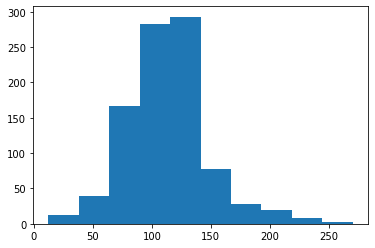

DescribeResult(nobs=930, minmax=(12.285012285012286, 270.40816326530614), mean=113.17774726055792, variance=1244.631879315503, skewness=0.7377113379336068, kurtosis=1.8212141329725053)
(0.963371217250824, 1.606787789030107e-14)


In [0]:
plt.hist(re_sales_spring_updated['price_per_sqft'])
plt.show()

print(stats.describe(re_sales_spring_updated['price_per_sqft']))
print(stats.shapiro(re_sales_spring_updated['price_per_sqft']))

### Summer Testing

In [0]:
no_zeros_sqft_summer = re_sales_summer['htdsqft'] > 0

re_sales_summer_updated = re_sales_spring.iloc[no_zeros_sqft.values]

re_sales_summer_updated = re_sales_summer_updated.assign(price_per_sqft = ((re_sales_summer_updated.sale_price) / (re_sales_summer_updated.htdsqft)))

re_sales_summer_updated.describe()

,htdsqft,acres,sale_price,price_per_sqft
count,930.000000,930.000000,930.000000,930.000000
mean,1486.817204,0.192368,168141.290323,113.177747
std,521.255583,0.190876,74531.623637,35.279341
min,515.000000,0.010000,22000.000000,12.285012
25%,1133.500000,0.030000,115000.000000,90.931818
50%,1363.000000,0.170000,151750.000000,111.900235
75%,1733.750000,0.270000,218500.000000,130.571494
max,4681.000000,1.890000,394000.000000,270.408163


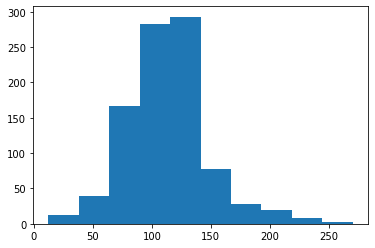

DescribeResult(nobs=930, minmax=(12.285012285012286, 270.40816326530614), mean=113.17774726055792, variance=1244.631879315503, skewness=0.7377113379336068, kurtosis=1.8212141329725053)
(0.963371217250824, 1.606787789030107e-14)


In [0]:
plt.hist(re_sales_summer_updated['price_per_sqft'])
plt.show()

print(stats.describe(re_sales_summer_updated['price_per_sqft']))
print(stats.shapiro(re_sales_summer_updated['price_per_sqft']))

### Autumn Testing

In [0]:
no_zeros_sqft_autumn = re_sales_autumn['htdsqft'] > 0

re_sales_autumn_updated = re_sales_autumn.iloc[no_zeros_sqft_autumn.values]

re_sales_autumn_updated = re_sales_autumn_updated.assign(price_per_sqft = ((re_sales_autumn_updated.sale_price) / (re_sales_autumn_updated.htdsqft)))

re_sales_autumn_updated.describe()

,htdsqft,acres,sale_price,price_per_sqft
count,570.000000,570.000000,570.000000,570.000000
mean,1503.924561,0.218184,169988.345614,112.357959
std,492.001853,0.445759,75554.612460,35.032840
min,531.000000,0.000000,33000.000000,25.388765
25%,1172.000000,0.076250,119225.000000,90.474056
50%,1402.000000,0.190000,156250.000000,112.929584
75%,1741.250000,0.260000,216750.000000,131.661833
max,4582.000000,10.000000,399000.000000,398.671096


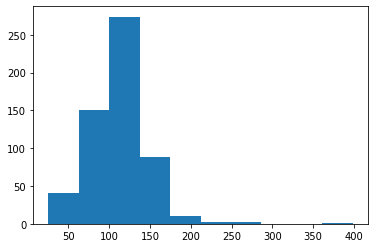

DescribeResult(nobs=570, minmax=(25.38876547127896, 398.67109634551497), mean=112.3579589002626, variance=1227.2999065860938, skewness=1.2290675880343405, kurtosis=8.50098148681751)
(0.9305803179740906, 1.3500692974861579e-15)


In [0]:
plt.hist(re_sales_autumn_updated['price_per_sqft'])
plt.show()

print(stats.describe(re_sales_autumn_updated['price_per_sqft']))
print(stats.shapiro(re_sales_autumn_updated['price_per_sqft']))

### Winter Testing

In [0]:
no_zeros_sqft_winter = re_sales_winter['htdsqft'] > 0

re_sales_winter_updated = re_sales_winter.iloc[no_zeros_sqft_winter.values]

re_sales_winter_updated = re_sales_winter_updated.assign(price_per_sqft = ((re_sales_winter_updated.sale_price) / (re_sales_winter_updated.htdsqft)))

re_sales_winter_updated.describe()

,htdsqft,acres,sale_price,price_per_sqft
count,579.000000,579.000000,579.000000,579.000000
mean,1459.466321,0.179979,163271.207254,110.948365
std,485.558769,0.152139,73564.072168,33.655299
min,267.000000,0.000000,23000.000000,28.376844
25%,1138.500000,0.045000,112000.000000,89.773814
50%,1361.000000,0.170000,150000.000000,109.489051
75%,1764.500000,0.255000,217100.000000,129.320299
max,3160.000000,1.110000,392500.000000,268.817204


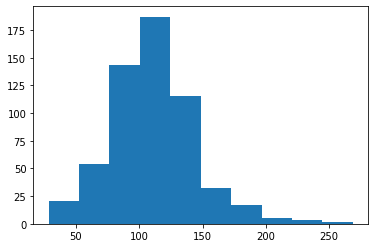

DescribeResult(nobs=579, minmax=(28.37684449489217, 268.81720430107526), mean=110.94836462639992, variance=1132.6791538279126, skewness=0.7098522981755663, kurtosis=2.1363983726322404)
(0.967106819152832, 4.2166553582134725e-10)


In [0]:
plt.hist(re_sales_winter_updated['price_per_sqft'])
plt.show()

print(stats.describe(re_sales_winter_updated['price_per_sqft']))
print(stats.shapiro(re_sales_winter_updated['price_per_sqft']))

### Comparing Seasonality by price per squarefoot

In [0]:
# I realize now I have to clean htdsqft for the whole data set. *sad noises*

no_zeros_sqft_total = re_sales_cleanish['htdsqft'] > 0

re_sales_final =  re_sales_cleanish.iloc[no_zeros_sqft_total.values]

re_sales_final = re_sales_final.assign(price_per_sqft = ((re_sales_final.sale_price) / (re_sales_final.htdsqft)))

re_sales_final.describe()

,htdsqft,acres,sale_price,price_per_sqft
count,3060.000000,3060.000000,3060.000000,3060.000000
mean,1482.064052,0.199614,167213.818954,112.237198
std,499.206364,0.285201,74543.525309,34.246660
min,267.000000,0.000000,22000.000000,12.285012
25%,1141.000000,0.040000,114900.000000,90.909091
50%,1370.000000,0.180000,153850.000000,111.822890
75%,1746.250000,0.260000,217000.000000,130.210288
max,4681.000000,10.000000,399000.000000,405.263158


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f095f1e7400>,
      dtype=object)

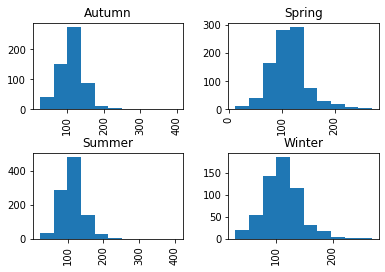

In [0]:
re_sales_final['price_per_sqft'].hist(by = re_sales_cleanish['Season'])

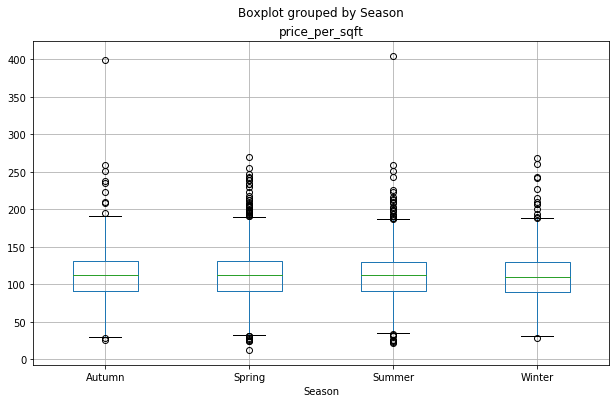

In [0]:
re_sales_final.boxplot('price_per_sqft', by='Season', figsize=(10, 6))

In [0]:
# Anova test - from the Anova test there doesn't seem to be a significant difference in price per sqft

stats.f_oneway(re_sales_spring_updated['price_per_sqft'], re_sales_summer_updated['price_per_sqft'], re_sales_autumn_updated['price_per_sqft'], re_sales_winter_updated['price_per_sqft'])

F_onewayResult(statistic=0.6103572114470143, pvalue=0.6082515568703708)

In [0]:
# Tukey further shows that the mean price per squarefoot fails to reject the null across all groups
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog = re_sales_final['price_per_sqft'],      
                          groups = re_sales_final['Season'],  
                          alpha=0.05)         
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Autumn,Spring,0.8198,0.9,-3.864,5.5036,False
Autumn,Summer,-0.3219,0.9,-4.9592,4.3154,False
Autumn,Winter,-1.4096,0.8937,-6.6049,3.7857,False
Spring,Summer,-1.1417,0.8764,-5.1715,2.8881,False
Spring,Winter,-2.2294,0.5951,-6.8905,2.4318,False
Summer,Winter,-1.0877,0.9,-5.7021,3.5267,False


### Conclusion

Again failed to refute the null hypothesis. Not sure if it's because the range of values is too wide to accurately determine a solid mean value, but the distributions seemed normal for the most part.

I was hopeful this time since the histograms appeared different on first glance, but the pvalues provided proved to be just too big.

I feel there is significance to the difference in the number of transactions, but perhaps this isn't the data to prove it. Worried about bias kicking in if I keep digging and segmenting the data further.